In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
## convert one to multiple series
def distri_plot(df):
    n_col = len(df.columns)
    f, axes = plt.subplots(n_col // 4 + 1,  4, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= n_col):
            return
        ## jump to plotting energy
        sns.kdeplot(df[col_name],ax=axes[idx//4,idx%4], bw = .05, color="olive", shade= True)  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    n_col = len(df.columns)
    f, axes = plt.subplots(n_col//4 +1, 4, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= n_col):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = df.columns[-1], data = df, ax=axes[idx//4,idx%4])  
    ## plot     
    plt.tight_layout()


def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## plot dataframe creation
def plot_df(arr, name):
    plot_df = pd.DataFrame()
    i = 0
    for row in arr:
        plot_df.insert(i, "{}".format(name), row, True) 
        i += 1
    return plot_df

def get_eval(y, yhat):
    print("MSE: {}".format(mean_squared_error(y,yhat)))
    print("MAE: {}".format(mean_absolute_error(y,yhat)))
    print("r2_score: {}".format(r2_score(y,yhat, multioutput = "variance_weighted")))

In [3]:
train = pd.read_csv("../data/elia_2019.csv", index_col= 'time')
test = pd.read_csv("../data/test_elia.csv", index_col= 'time')

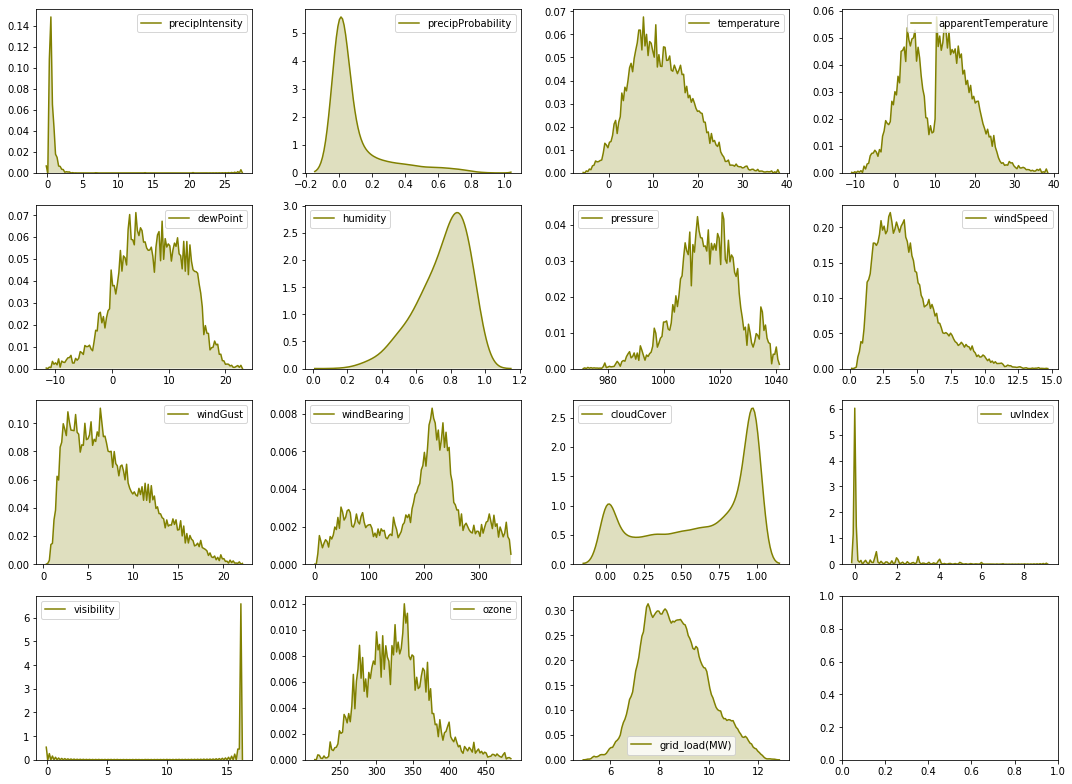

In [4]:
distri_plot(train)

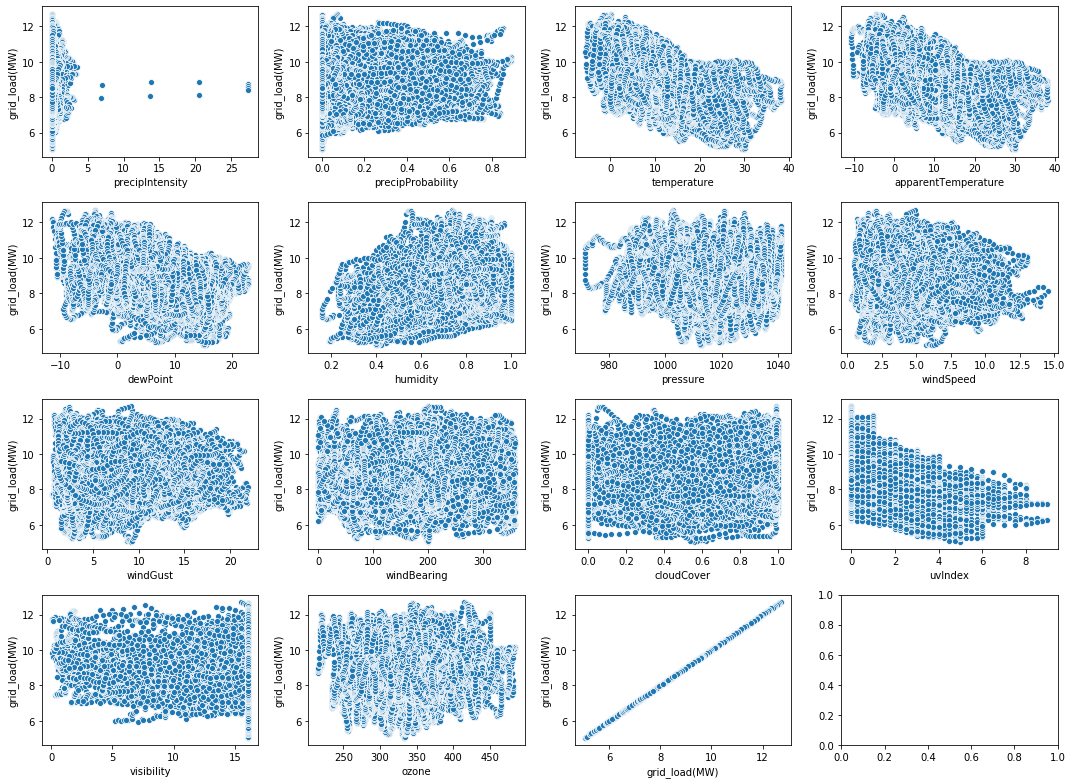

In [5]:
scatter_plot(train)

In [4]:
#create 12 hours recency effect matrix
ahead_w = lag_ahead_series(train.iloc[:,2], n_in=0, n_out=25, n_vars = 1, dropnan=True)
#create 12 housrs ahead energy consumption matrix
ahead_e = lag_ahead_series(train.iloc[:,14], n_in=0, n_out=25, n_vars = 1, dropnan=True)
ahead_w.shape, ahead_e.shape

((35017, 25), (35017, 25))

In [5]:
test_X = lag_ahead_series(test.iloc[:,2], n_in=0, n_out=25, n_vars = 1, dropnan=True).iloc[:100,:]
test_y = lag_ahead_series(test.iloc[:,14], n_in=0, n_out=25, n_vars = 1, dropnan=True).iloc[:100,:]
test_X.shape, test_y.shape

((100, 25), (100, 25))

In [45]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
ahead_e = mms.fit_transform(ahead_e)
test_y = mms.transform(test_y)

### TPOT: 6 hour ahead, 15 mins

In [ ]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.1, random_state = 321)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -1.0067312611704344
Generation 2 - Current best internal CV score: -1.0067312611704344
Generation 3 - Current best internal CV score: -0.9409702804961796
Generation 4 - Current best internal CV score: -0.9290686902475265
Generation 5 - Current best internal CV score: -0.9290686902475265
Generation 6 - Current best internal CV score: -0.9290686902475265
Generation 7 - Current best internal CV score: -0.9290686902475265
Generation 8 - Current best internal CV score: -0.9153422661594345
Generation 9 - Current best internal CV score: -0.9144432649699545


In [6]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, random_state = 321)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -1.0903133806510668
Generation 2 - Current best internal CV score: -1.0735122062432576
Generation 3 - Current best internal CV score: -1.0735122062432576
Generation 4 - Current best internal CV score: -1.0522355935768641
Generation 5 - Current best internal CV score: -1.0522355935768641
Generation 6 - Current best internal CV score: -1.044556785112134
Generation 7 - Current best internal CV score: -1.0357064175892225
Generation 8 - Current best internal CV score: -1.0357064175892225
Generation 9 - Current best internal CV score: -1.0153236116598952
Generation 10 - Current best internal CV score: -1.0153236116598952
Generation 11 - Current best internal CV score: -1.0153236116598952
Generation 12 - Current best internal CV score: -1.0153236116598952
Generation 13 - Current best internal CV score: -1.0153236116598952
Generation 14 - Current best internal CV score: -1.0153236116598952
Generation 15 - Current best internal CV score: -1.0153236

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [7]:
#val_X, val_y = train.iloc[500:600,:8], ahead_e.iloc[500:600,:]
yhat = tpot_reg.predict(test_X)

### Result Evaluation

In [8]:
get_eval(test_y, yhat)

MSE: 1.933086573501877
MAE: 1.1608659351298
r2_score: -0.9161116251369165


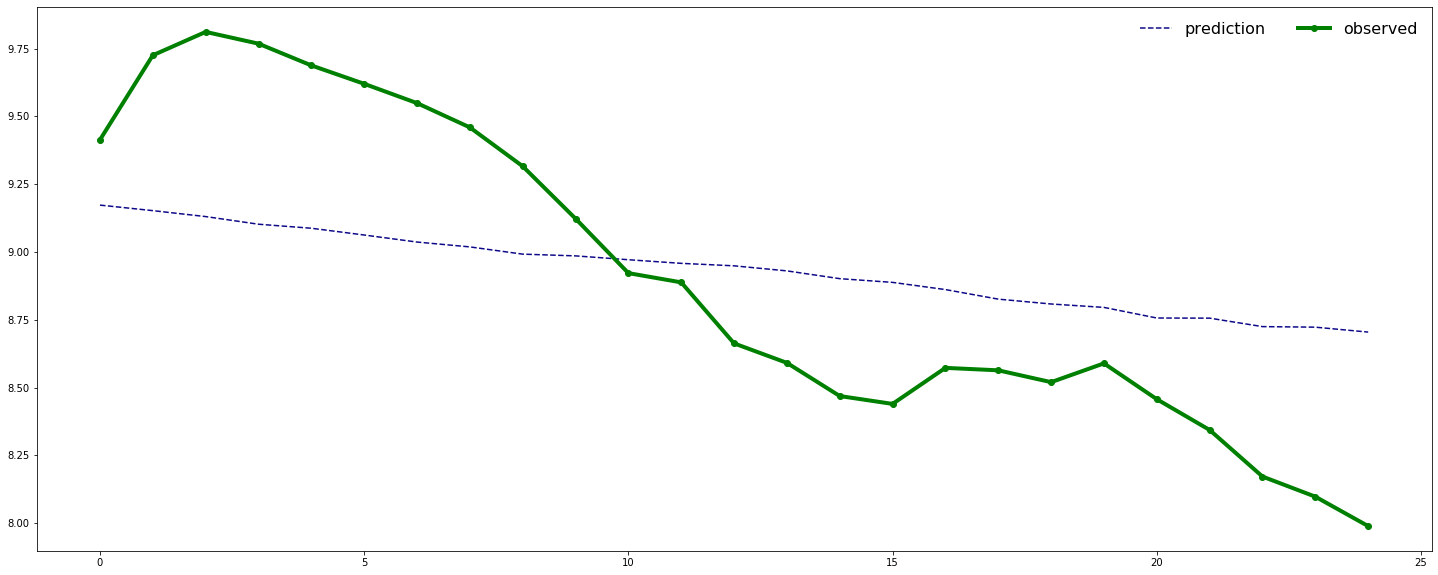

In [10]:
## assignment
real = test_y.to_numpy()
guess = yhat

real = real[50:51,:]
guess = guess[50:51,:]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()

### TPOT: 24 hour ahead, half-hourly

In [7]:
from tpot import TPOTRegressor
from tpot_mulr import mul_reg_config_dict
from sklearn.model_selection import train_test_split
#import mul_config as mc

train_X, val_X, train_y, val_y = train_test_split(ahead_w, ahead_e, train_size = 0.05, test_size = 0.95, random_state = 123)

tpot_reg = TPOTRegressor(generations=30, 
                         population_size=60, 
                         n_jobs=4, 
                         verbosity=2, 
                         random_state=123,
                         subsample= 0.8,
                         config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X , train_y)


Generation 1 - Current best internal CV score: -0.002535817417579815
Generation 2 - Current best internal CV score: -0.002530690697956506
Generation 3 - Current best internal CV score: -0.002530690697956506
Generation 4 - Current best internal CV score: -0.002510051020902841
Generation 5 - Current best internal CV score: -0.002510051020902841
Generation 6 - Current best internal CV score: -0.002510051020902841
Generation 7 - Current best internal CV score: -0.002491375270707632
Generation 8 - Current best internal CV score: -0.0024314059283892667
Generation 9 - Current best internal CV score: -0.0023766470404857337
Generation 10 - Current best internal CV score: -0.0023766470404857337
Generation 11 - Current best internal CV score: -0.0023766470404857337
Generation 12 - Current best internal CV score: -0.0023766470404857337
Generation 13 - Current best internal CV score: -0.002355760607122987
Generation 14 - Current best internal CV score: -0.002355760607122987
Generation 15 - Current 

TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [8]:
yhat = tpot_reg.predict(test_X)
mean_squared_error(test_y, yhat)
mean_absolute_error(test_y, yhat)
r2_score(test_y, yhat)

0.8708304000147385

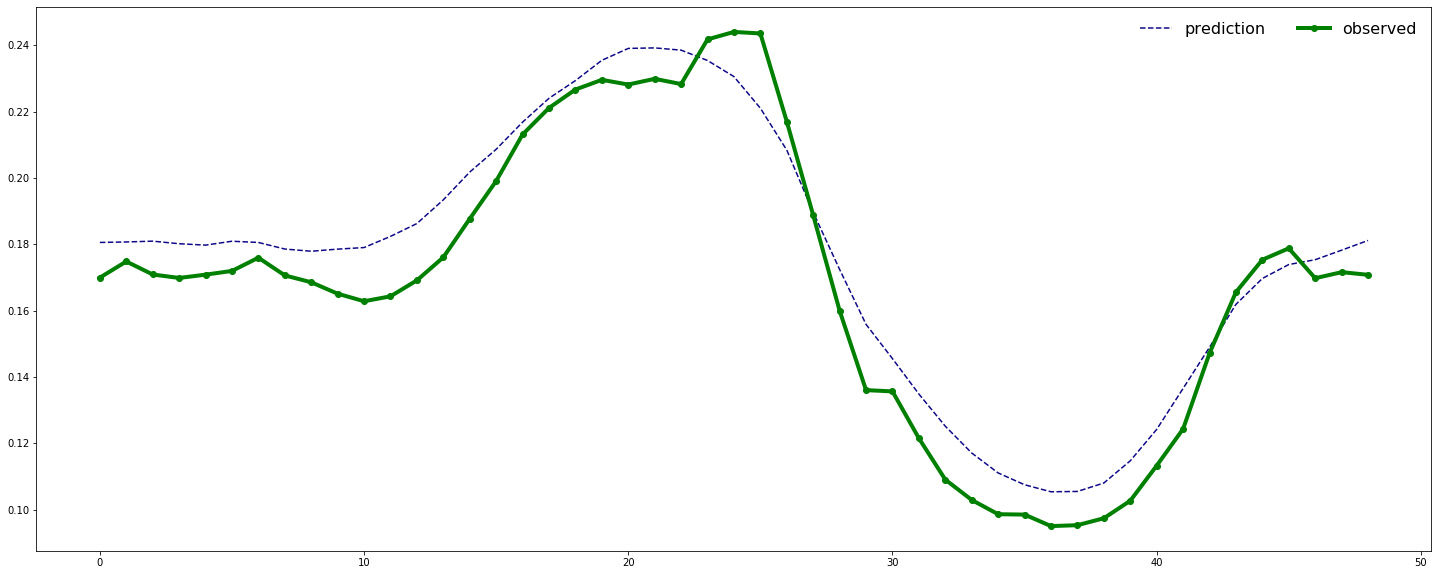

In [9]:
## assignment
real = test_y.to_numpy()
guess = yhat
real = real[50:51,:49]
guess = guess[50:51,:49]
rpdf = plot_df(real, "observed")
gpdf = plot_df(guess, "prediction")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='upper right', ncol=6, prop={'size': 16})

plt.show()